In [28]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [29]:
import pandas as pd

In [30]:
# Load the merged dataset
file_path = "merged_wta_environmental_data_with_fixed_geo.csv"  # Ensure the file exists in the working directory
merged_data = pd.read_csv(file_path)

# Display first few rows to confirm data structure
print("Dataset Loaded. Sample Data:")
display(merged_data.head())

Dataset Loaded. Sample Data:


,Date_sb,Date of Session,Day of Session,Month of Session,Numerical Value of Month,Year_sb,Date_c,Epoch,Date Reverse,Week,...,Air Temperature,Ground Temperature,Relative Humidity_catapult,Type Of Day,AQI Reading_catapult,event-uuid_catapult,group-uuid_catapult,City,Latitude,Longitude
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.2,35.0,20.0,Sunny,NaN,67acd904-6b3f-42b4-8193-c0072e2d1197,5d55d609-6b95-4ec3-ad0d-08a0c1f9e38c,ABU DHABI,24.453835,54.377401
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.7,36.9,20.9,Sunny,27.0,67acd904-6b3f-42b4-8193-c0072e2d1197,5d55d609-6b95-4ec3-ad0d-08a0c1f9e38c,ABU DHABI,24.453835,54.377401
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25.3,39.1,14.0,Sunny,NaN,67acd904-6b3f-42b4-8193-c0072e2d1197,5d55d609-6b95-4ec3-ad0d-08a0c1f9e38c,ABU DHABI,24.453835,54.377401
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.9,35.3,8.0,Sunny,35.0,67acd904-6b3f-42b4-8193-c0072e2d1197,5d55d609-6b95-4ec3-ad0d-08a0c1f9e38c,ABU DHABI,24.453835,54.377401
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.1,38.9,23.8,Sunny,NaN,67acd904-6b3f-42b4-8193-c0072e2d1197,5d55d609-6b95-4ec3-ad0d-08a0c1f9e38c,ABU DHABI,24.453835,54.377401


In [31]:
# Step 1: Normalize the EWCR values across Smartabase and Catapult
def normalize_ewcr(row):
    if pd.notnull(row['EWCR']):
        val = row['EWCR'].strip()
        if val == 'OUT':
            return 'Out'
        elif 'Modification' in val:
            return 'In - Modification'
        elif 'Suspension' in val:
            return 'In - Suspension'
    elif pd.notnull(row['Heat Rule In/out']):
        val = row['Heat Rule In/out'].strip().lower()
        if val == 'in':
            return 'In'
        elif val == 'out':
            return 'Out'
    return 'Unknown'

merged_data['EWCR_Standardized'] = merged_data.apply(normalize_ewcr, axis=1)

# Step 2: Create a unified Year column
merged_data['Year'] = merged_data['Year_sb'].combine_first(merged_data['Year_catapult'])

# Step 3: Create a unified Tournament/Location column
merged_data['Tournament_Clean'] = merged_data['Tournament'].combine_first(merged_data['Label']).combine_first(merged_data['City'])

# Step 4: Group by Year and Tournament/City and count EWCR statuses
ewcr_counts = (
    merged_data
    .groupby(['Year', 'Tournament_Clean', 'EWCR_Standardized'])
    .size()
    .reset_index(name='Count')
)

# Step 5: Pivot the table for cleaner visualization
ewcr_pivot = ewcr_counts.pivot_table(index=['Year', 'Tournament_Clean'],
                                     columns='EWCR_Standardized',
                                     values='Count',
                                     fill_value=0).reset_index()

# Display results
# Display the dataframe using pandas
print("EWCR Status Frequency by Year and Tournament/City:")
display(ewcr_pivot)

EWCR Status Frequency by Year and Tournament/City:


EWCR_Standardized,Year,Tournament_Clean,In,In - Modification,In - Suspension,Out,Unknown
0,2021.0,2021 - ABU DHABI,0.0,0.0,0.0,19.0,1.0
1,2021.0,2021 - ADELAIDE 500,0.0,0.0,0.0,16.0,0.0
2,2021.0,2021 - AUSTRALIAN OPEN,0.0,0.0,0.0,8.0,0.0
3,2021.0,2021 - BAD HOMBURG,0.0,0.0,0.0,9.0,1.0
4,2021.0,2021 - BASTAD 125,0.0,0.0,0.0,15.0,0.0
...,...,...,...,...,...,...,...
277,2024.0,2024 - WUHAN 1000,0.0,0.0,0.0,23.0,0.0
278,2024.0,2025 - ADELAIDE 500,0.0,0.0,0.0,0.0,1.0
279,2024.0,2025 - AUCKLAND 250,0.0,0.0,0.0,22.0,0.0
280,2024.0,2025 - BRISBANE 500,0.0,0.0,0.0,0.0,3.0


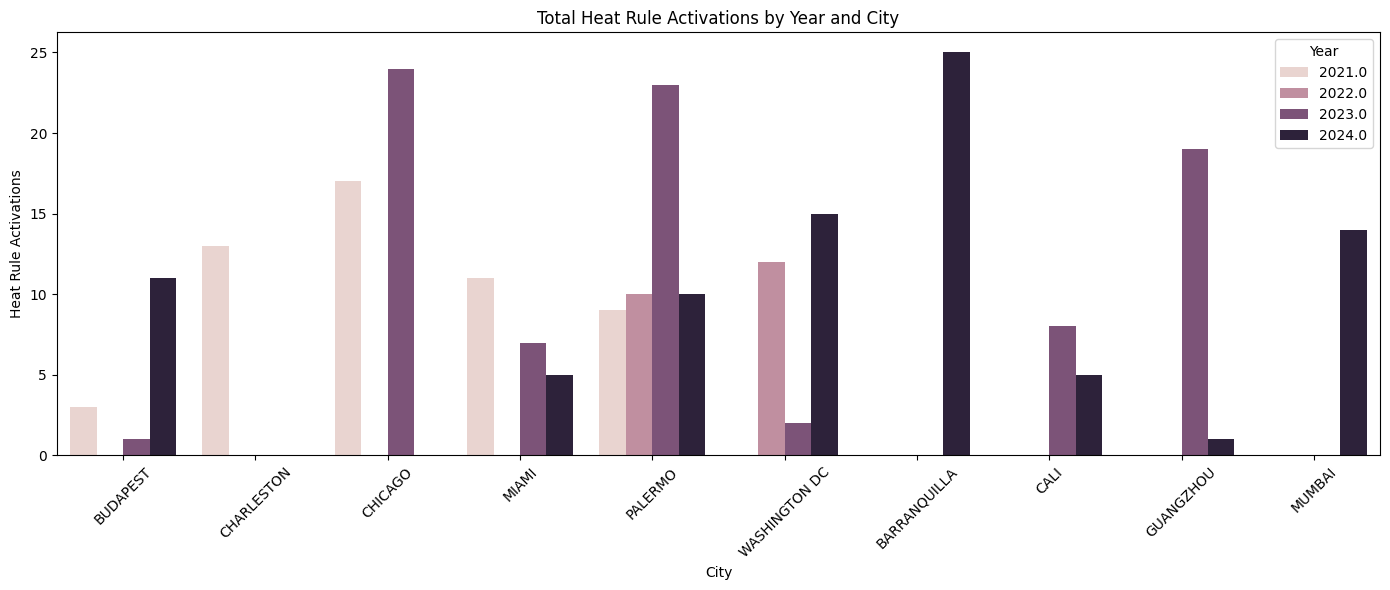

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Ensure your columns are filled and calculated
ewcr_pivot['In'] = ewcr_pivot.get('In', 0).fillna(0)
ewcr_pivot['In - Modification'] = ewcr_pivot.get('In - Modification', 0).fillna(0)
ewcr_pivot['In - Suspension'] = ewcr_pivot.get('In - Suspension', 0).fillna(0)
ewcr_pivot['Total_Heat_Rule_Events'] = (
    ewcr_pivot['In'] + ewcr_pivot['In - Modification'] + ewcr_pivot['In - Suspension']
)

# Step 2: Merge city info back in
heat_with_city = ewcr_pivot.merge(
    merged_data[['Year', 'Tournament_Clean', 'City']].drop_duplicates(),
    on=['Year', 'Tournament_Clean'],
    how='left'
)

# Step 3: Group by year and city
heat_by_year_city = (
    heat_with_city
    .groupby(['Year', 'City'])['Total_Heat_Rule_Events']
    .sum()
    .reset_index()
)

# Optional: filter top cities by total events
top_cities = (
    heat_by_year_city.groupby('City')['Total_Heat_Rule_Events']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)
heat_by_year_city = heat_by_year_city[heat_by_year_city['City'].isin(top_cities)]

# Step 4: Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=heat_by_year_city, x='City', y='Total_Heat_Rule_Events', hue='Year')

plt.title("Total Heat Rule Activations by Year and City")
plt.ylabel("Heat Rule Activations")
plt.xlabel("City")
plt.legend(title="Year")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

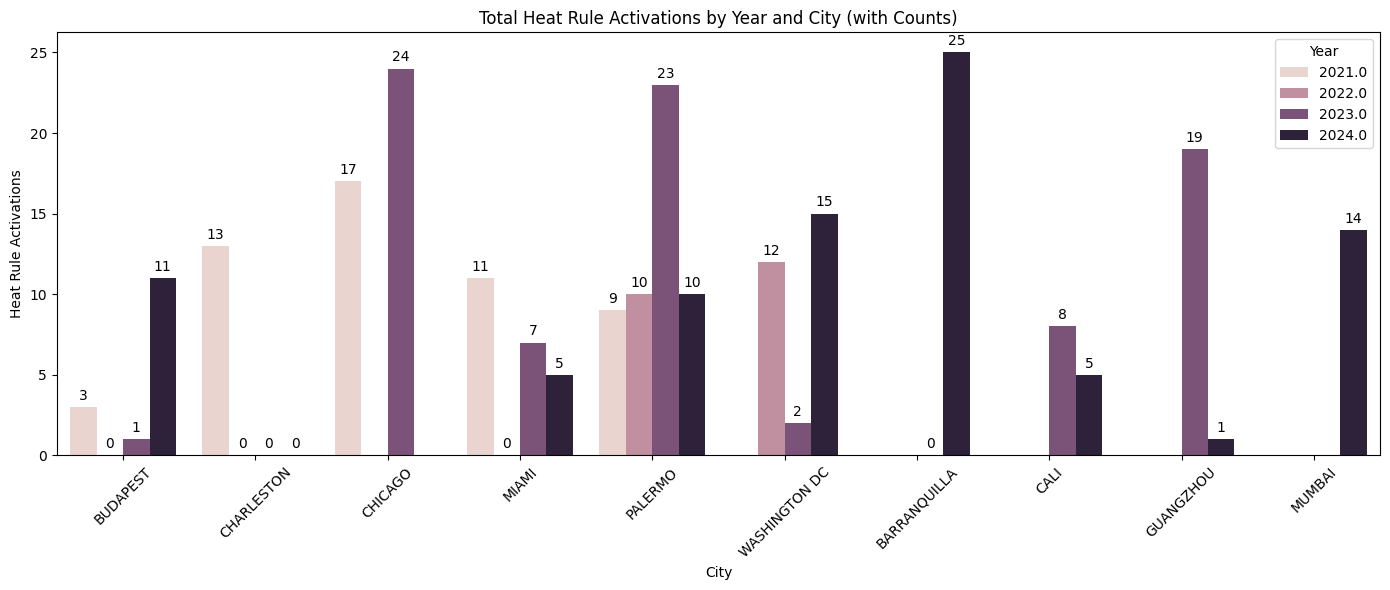

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot again
plt.figure(figsize=(14, 6))
barplot = sns.barplot(
    data=heat_by_year_city,
    x='City',
    y='Total_Heat_Rule_Events',
    hue='Year'
)

# Add text labels on top of bars
for container in barplot.containers:
    barplot.bar_label(container, fmt='%d', label_type='edge', padding=3)

# Axis & title formatting
plt.title("Total Heat Rule Activations by Year and City (with Counts)")
plt.ylabel("Heat Rule Activations")
plt.xlabel("City")
plt.xticks(rotation=45)
plt.legend(title="Year")
plt.tight_layout()
plt.show()

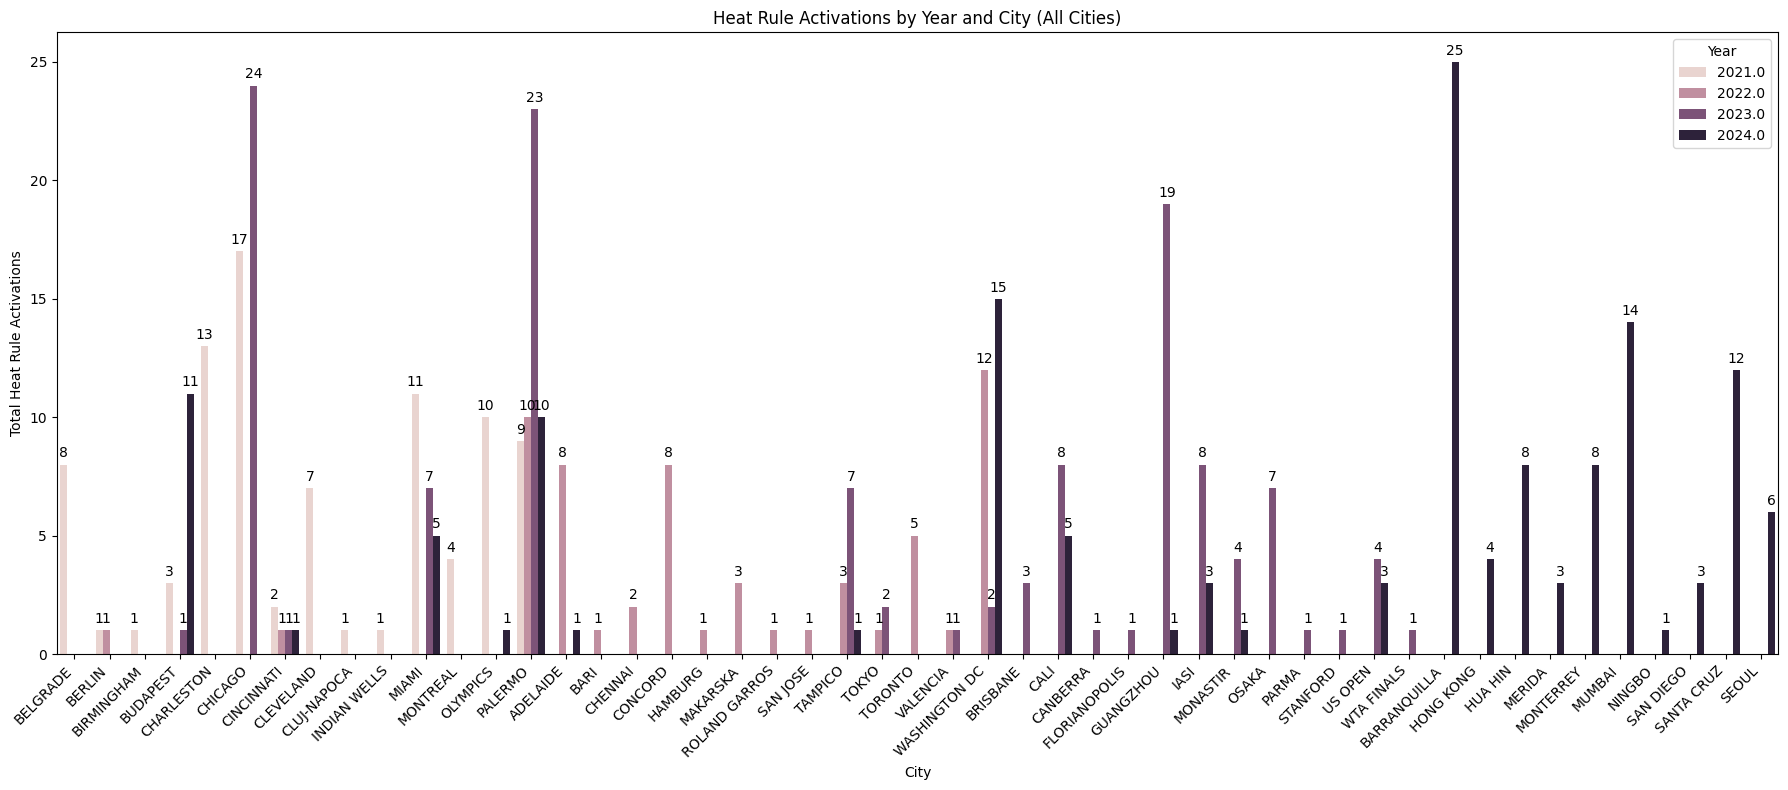

In [41]:
# Recalculate if needed
ewcr_pivot['In'] = ewcr_pivot.get('In', 0).fillna(0)
ewcr_pivot['In - Modification'] = ewcr_pivot.get('In - Modification', 0).fillna(0)
ewcr_pivot['In - Suspension'] = ewcr_pivot.get('In - Suspension', 0).fillna(0)
ewcr_pivot['Total_Heat_Rule_Events'] = (
    ewcr_pivot['In'] + ewcr_pivot['In - Modification'] + ewcr_pivot['In - Suspension']
)

# Merge city back into pivot table
heat_with_city = ewcr_pivot.merge(
    merged_data[['Year', 'Tournament_Clean', 'City']].drop_duplicates(),
    on=['Year', 'Tournament_Clean'],
    how='left'
)

# Group by year and city — this time WITHOUT filtering to top cities
heat_by_year_city_all = (
    heat_with_city
    .dropna(subset=['City'])  # only keep rows with city info
    .groupby(['Year', 'City'])['Total_Heat_Rule_Events']
    .sum()
    .reset_index()
)

# Optional: remove cities with all zero counts
heat_by_year_city_all = heat_by_year_city_all[heat_by_year_city_all['Total_Heat_Rule_Events'] > 0]

# Plot
plt.figure(figsize=(18, 8))  # Larger size for more cities
barplot = sns.barplot(data=heat_by_year_city_all, x='City', y='Total_Heat_Rule_Events', hue='Year')

# Add count labels to each bar
for container in barplot.containers:
    barplot.bar_label(container, fmt='%d', label_type='edge', padding=3)

# Format axes and labels
plt.title("Heat Rule Activations by Year and City (All Cities)")
plt.xlabel("City")
plt.ylabel("Total Heat Rule Activations")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Year")
plt.tight_layout()
plt.show()

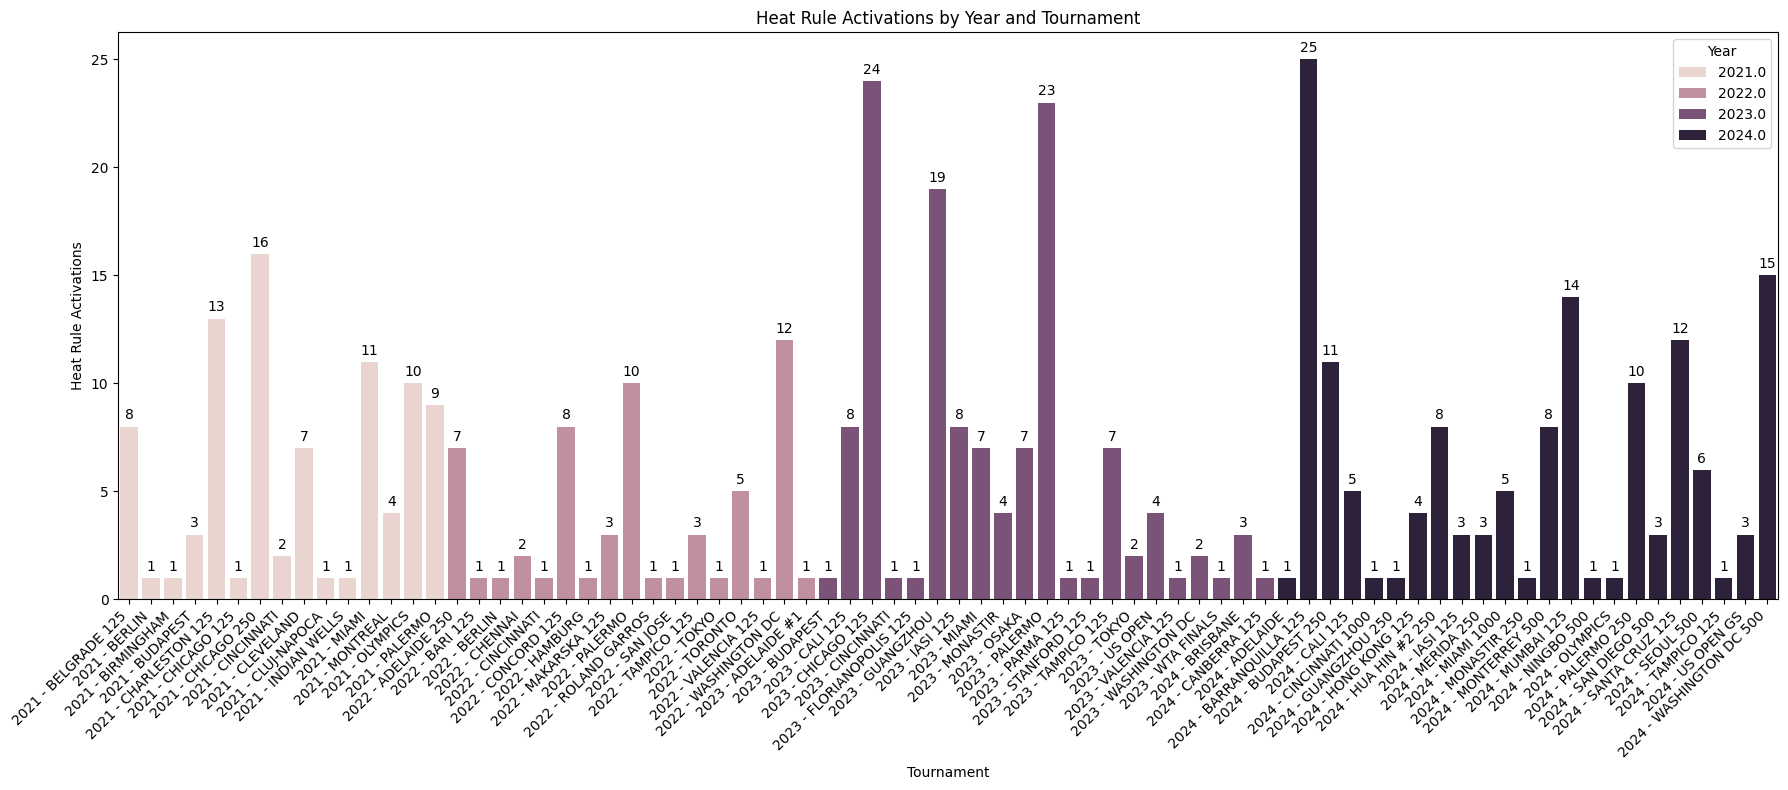

In [42]:
heat_with_tournament = ewcr_pivot.merge(
    merged_data[['Year', 'Tournament_Clean']].drop_duplicates(),
    on=['Year', 'Tournament_Clean'],
    how='left'
)

# Group by year and tournament
heat_by_year_tournament = (
    heat_with_tournament
    .groupby(['Year', 'Tournament_Clean'])['Total_Heat_Rule_Events']
    .sum()
    .reset_index()
)

# Optional: drop tournaments with 0 activations
heat_by_year_tournament = heat_by_year_tournament[heat_by_year_tournament['Total_Heat_Rule_Events'] > 0]

# Plot
plt.figure(figsize=(18, 8))
barplot = sns.barplot(data=heat_by_year_tournament, x='Tournament_Clean', y='Total_Heat_Rule_Events', hue='Year')

# Add value labels to each bar
for container in barplot.containers:
    barplot.bar_label(container, fmt='%d', label_type='edge', padding=3)

# Formatting
plt.title("Heat Rule Activations by Year and Tournament")
plt.xlabel("Tournament")
plt.ylabel("Heat Rule Activations")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Year")
plt.tight_layout()
plt.show()

In [9]:
# Filter the EWCR pivot table to only include rows where a heat rule was in effect
heat_rule_used = ewcr_pivot[
    (ewcr_pivot.get('In', 0) > 0) |
    (ewcr_pivot.get('In - Modification', 0) > 0) |
    (ewcr_pivot.get('In - Suspension', 0) > 0)
]
print("EWCR Status Frequency by Year and Tournament/City:")
display(heat_rule_used)

EWCR Status Frequency by Year and Tournament/City:


EWCR_Standardized,Year,Tournament_Clean,In,In - Modification,In - Suspension,Out,Unknown
6,2021.0,2021 - BELGRADE 125,8.0,0.0,0.0,9.0,0.0
7,2021.0,2021 - BERLIN,1.0,0.0,0.0,15.0,0.0
8,2021.0,2021 - BIRMINGHAM,1.0,0.0,0.0,9.0,10.0
11,2021.0,2021 - BUDAPEST,3.0,0.0,0.0,22.0,0.0
14,2021.0,2021 - CHARLESTON 125,13.0,0.0,0.0,4.0,0.0
...,...,...,...,...,...,...,...
266,2024.0,2024 - SANTA CRUZ 125,0.0,2.0,10.0,13.0,0.0
267,2024.0,2024 - SEOUL 500,0.0,6.0,0.0,8.0,1.0
269,2024.0,2024 - TAMPICO 125,0.0,1.0,0.0,13.0,0.0
272,2024.0,2024 - US OPEN GS,0.0,3.0,0.0,44.0,3.0


/var/folders/np/l7kf7rgn071d7c4hcsc3kc7w0000gn/T/ipykernel_24319/963210957.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_rule_used['Total_Heat_Rule_Events'] = (


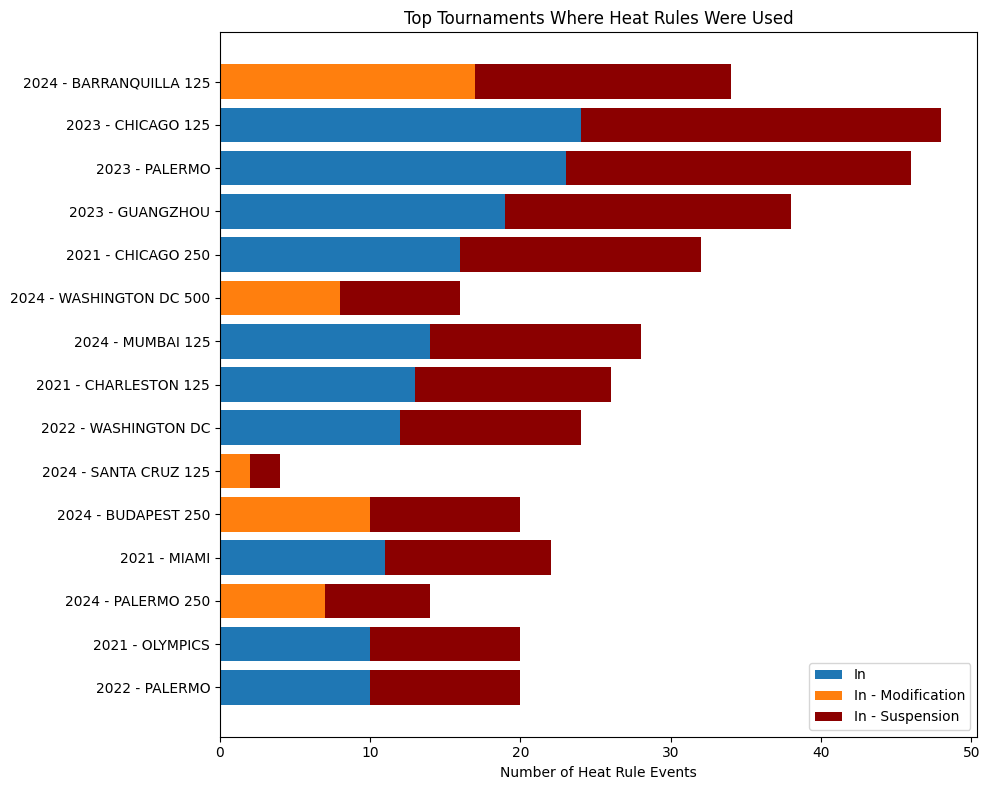

In [21]:
import matplotlib.pyplot as plt

# Limit to top 15 by total activations for readability (optional)
heat_rule_used['Total_Heat_Rule_Events'] = (
    heat_rule_used.get('In', 0).fillna(0) +
    heat_rule_used.get('In - Modification', 0).fillna(0) +
    heat_rule_used.get('In - Suspension', 0).fillna(0)
)

top_heat = heat_rule_used.sort_values(by='Total_Heat_Rule_Events', ascending=True).tail(15)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Stacked bars
ax.barh(top_heat['Tournament_Clean'], top_heat.get('In', 0), label='In')
ax.barh(top_heat['Tournament_Clean'],
        top_heat.get('In - Modification', 0),
        left=top_heat.get('In', 0),
        label='In - Modification')
ax.barh(top_heat['Tournament_Clean'],
        top_heat.get('In - Modification', 0) + top_heat.get('In', 0),
        left=top_heat.get('In - Modification', 0) + top_heat.get('In', 0),
        label='In - Suspension',
        color='darkred')

# Labels and title
ax.set_xlabel('Number of Heat Rule Events')
ax.set_title('Top Tournaments Where Heat Rules Were Used')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [16]:
heat_rule_used_clean = heat_rule_used.copy()

# Ensure relevant columns exist and fill NaNs with 0
heat_rule_used_clean['In'] = heat_rule_used_clean.get('In', 0).fillna(0)
heat_rule_used_clean['In - Modification'] = heat_rule_used_clean.get('In - Modification', 0).fillna(0)
heat_rule_used_clean['In - Suspension'] = heat_rule_used_clean.get('In - Suspension', 0).fillna(0)

# Step 1: Create Total_Heat_Rule_Events column
heat_rule_used_clean['Total_Heat_Rule_Events'] = (
    heat_rule_used_clean['In'] +
    heat_rule_used_clean['In - Modification'] +
    heat_rule_used_clean['In - Suspension']
)

# Step 2: Sort and get top 10
top10_heat_rule_tournaments = (
    heat_rule_used_clean
    .sort_values(by='Total_Heat_Rule_Events', ascending=False)
    .head(10)
)

print("EWCR Status Frequency by Year and Tournament/City:")
display(top10_heat_rule_tournaments)

EWCR Status Frequency by Year and Tournament/City:


EWCR_Standardized,Year,Tournament_Clean,In,In - Modification,In - Suspension,Out,Unknown,Total_Heat_Rule_Events
205,2024.0,2024 - BARRANQUILLA 125,0.0,17.0,8.0,14.0,16.0,25.0
132,2023.0,2023 - CHICAGO 125,24.0,0.0,0.0,7.0,0.0,24.0
168,2023.0,2023 - PALERMO,23.0,0.0,0.0,13.0,0.0,23.0
144,2023.0,2023 - GUANGZHOU,19.0,0.0,0.0,10.0,0.0,19.0
17,2021.0,2021 - CHICAGO 250,16.0,0.0,0.0,11.0,0.0,16.0
275,2024.0,2024 - WASHINGTON DC 500,0.0,8.0,7.0,14.0,1.0,15.0
248,2024.0,2024 - MUMBAI 125,14.0,0.0,0.0,14.0,1.0,14.0
14,2021.0,2021 - CHARLESTON 125,13.0,0.0,0.0,4.0,0.0,13.0
266,2024.0,2024 - SANTA CRUZ 125,0.0,2.0,10.0,13.0,0.0,12.0
110,2022.0,2022 - WASHINGTON DC,12.0,0.0,0.0,11.0,0.0,12.0


In [20]:
top10_with_city = top10_heat_rule_tournaments.merge(
    merged_data[['Year', 'Tournament_Clean', 'City']].drop_duplicates(),
    on=['Year', 'Tournament_Clean'],
    how='left'
)

# Step 2: Reorder columns if desired (e.g., move City earlier in the table)
cols = ['Year', 'Tournament_Clean', 'City','In', 'In - Modification', 'In - Suspension', 'Out', 'Unknown', 'Total_Heat_Rule_Events']
top10_with_city = top10_with_city[cols]

display(top10_with_city)

,Year,Tournament_Clean,City,In,In - Modification,In - Suspension,Out,Unknown,Total_Heat_Rule_Events
0,2024.0,2024 - BARRANQUILLA 125,BARRANQUILLA,0.0,17.0,8.0,14.0,16.0,25.0
1,2023.0,2023 - CHICAGO 125,CHICAGO,24.0,0.0,0.0,7.0,0.0,24.0
2,2023.0,2023 - PALERMO,PALERMO,23.0,0.0,0.0,13.0,0.0,23.0
3,2023.0,2023 - GUANGZHOU,GUANGZHOU,19.0,0.0,0.0,10.0,0.0,19.0
4,2021.0,2021 - CHICAGO 250,CHICAGO,16.0,0.0,0.0,11.0,0.0,16.0
5,2024.0,2024 - WASHINGTON DC 500,WASHINGTON DC,0.0,8.0,7.0,14.0,1.0,15.0
6,2024.0,2024 - MUMBAI 125,MUMBAI,14.0,0.0,0.0,14.0,1.0,14.0
7,2021.0,2021 - CHARLESTON 125,CHARLESTON,13.0,0.0,0.0,4.0,0.0,13.0
8,2024.0,2024 - SANTA CRUZ 125,SANTA CRUZ,0.0,2.0,10.0,13.0,0.0,12.0
9,2022.0,2022 - WASHINGTON DC,WASHINGTON DC,12.0,0.0,0.0,11.0,0.0,12.0
